# A study on the potential influencing factors of immigration to Canada
### CSCI 6405 - Data Mining Project, Dalhousie University.
### Hongwei Zhang, January - April 2023.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy.cluster.hierarchy as sch

# Experiment 1: Study the reasons why Canadian immigrants leave their home countries.
### Datasets used: The number of immigrants in Canada by country for the last decade (2011-2021), and economic and social indicators for the corresponding country.

In [2]:
# Organizing and processing Canadian immigration dataset.
im = pd.read_csv("Datasets/immigrants.csv", skiprows=14, nrows=215)
im.columns=['Birthplace', '1980-1990', '1991-2000', '2001-2010', '2011-2021']

for i in range(len(im)):
    if im['Birthplace'][i][-2:].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-3]
    if im['Birthplace'][i][-1].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-2]

    im['1980-1990'][i] = int(im['1980-1990'][i].replace(',', ''))
    im['1991-2000'][i] = int(im['1991-2000'][i].replace(',', ''))
    im['2001-2010'][i] = int(im['2001-2010'][i].replace(',', ''))
    im['2011-2021'][i] = int(im['2011-2021'][i].replace(',', ''))
    if im['1980-1990'][i] == 0 and im['1991-2000'][i] == 0 and im['2001-2010'][i] == 0 and im['2011-2021'][i] == 0:
        im=im.drop(labels=i)

im = im.sort_values(by=['Birthplace'])
im.reset_index(drop=True, inplace=True)

print("Number of country/region:", len(im))
im.head()

Number of country/region: 200


,Birthplace,1980-1990,1991-2000,2001-2010,2011-2021
0,Afghanistan,3920,14745,22280,21340
1,Albania,15,4130,8000,5500
2,Algeria,1345,11745,32430,32580
3,Andorra,0,0,0,30
4,Angola,415,390,1315,580


In [5]:
# Filtering data from each dataset for 2011 and 2021.
'''
Dataset name and meaning:
gdp: GDP per capita (current US$), GDP11 = GDP per capita for 2011, GDP21 = GDP per capita for 2021.
life: Life expectancy at birth, total (years), LE11, LE21.
inflation: Inflation, consumer prices (annual %), IF11, IF21.
unemployment: Unemployment, total (% of total labor force) (national estimate), UE11, UE21.
health: Current health expenditure (% of GDP), HE11, HE21.
education: Government expenditure on education, total (% of GDP), ED11, ED21.
'''

gdp = pd.read_csv("Datasets/gdp.csv", skiprows=4, nrows=266, usecols=[0, 55, 65])
gdp.columns = ['Birthplace', 'GDP11', 'GDP21']
life = pd.read_csv("Datasets/life.csv", skiprows=4, usecols=[55, 65])
life.columns = ['LE11', 'LE21']
inflation = pd.read_csv("Datasets/inflation.csv", skiprows=4, usecols=[55, 65])
inflation.columns = ['IF11', 'IF21']
unemployment = pd.read_csv("Datasets/unemployment.csv", skiprows=4, usecols=[55, 65])
unemployment.columns = ['UE11', 'UE21']
health = pd.read_csv("Datasets/health.csv", skiprows=4, usecols=[55, 65])
health.columns = ['HE11', 'HE21']
education = pd.read_csv("Datasets/education.csv", skiprows=4, usecols=[55, 65])
education.columns = ['ED11', 'ED21']

comb = pd.concat([gdp, life, inflation, unemployment, health, education], axis=1)
print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 266


,Birthplace,GDP11,GDP21,LE11,LE21,IF11,IF21,UE11,UE21,HE11,HE21,ED11,ED21
0,Aruba,26044.435933,29342.100858,75.465000,NaN,4.316297,NaN,8.90,NaN,NaN,NaN,6.11913,NaN
1,Africa Eastern and Southern,1792.847428,1537.336021,59.293271,NaN,8.971206,6.079328,NaN,NaN,6.774233,NaN,4.38598,NaN
2,Afghanistan,621.912311,368.754614,61.419000,NaN,11.804186,NaN,NaN,NaN,8.561907,NaN,3.46201,NaN
3,Africa Western and Central,1856.687669,1757.030626,55.013138,NaN,4.018699,3.837868,NaN,NaN,3.547476,NaN,2.66890,NaN
4,Angola,4511.153227,1953.533757,57.596000,NaN,13.482468,25.754266,7.36,NaN,2.645608,NaN,3.03000,NaN


In [13]:
# Use the data imputation algorithm to fill in the missing data.

def imputation (file, data, col1, col2):  # csv file, table, index of the two columns need to be filled.
    f = pd.read_csv(file, skiprows=4, usecols=range(35, 66)).to_numpy()  # 1991-2021

    for i in range(len(data)):
        # Find the location of the missing data and read all data from the dataset for a certain time range.
        if math.isnan(data.iloc[[i], [col1]].values) or math.isnan(data.iloc[[i], [col2]].values):
            row = []
            for j in f[i]:
                if not math.isnan(j):
                    row.append(j)

            # If there are more than ten data exist, choose two data that are ten years apart.
            if len(row) >= 10:
                data.iloc[[i], [col1]] = row[len(row) - 10]
                data.iloc[[i], [col2]] = row[-1]
            # Otherwise, select the first and last one.
            elif 1 < len(row) < 10:
                data.iloc[[i], [col1]] = row[0]
                data.iloc[[i], [col2]] = row[-1]
            row.clear()


imputation("Datasets/gdp.csv", comb, 1, 2)
imputation("Datasets/life.csv", comb, 3, 4)
imputation("Datasets/inflation.csv", comb, 5, 6)
imputation("Datasets/unemployment.csv", comb, 7, 8)
imputation("Datasets/health.csv", comb, 9, 10)
imputation("Datasets/education.csv", comb, 11, 12)

# For countries or regions with too much missing data, they are removed because they cannot be imputed.
comb.dropna(axis=0,subset = ['GDP11', 'GDP21', 'LE11', 'LE21', 'IF11', 'IF21', 'UE11', 'UE21', 'HE11', 'HE21', 'ED11', 'ED21'], inplace=True)
comb = comb.sort_values(by=['Birthplace'])
comb.reset_index(drop=True, inplace=True)
print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 205


,Birthplace,GDP11,GDP21,LE11,LE21,IF11,IF21,UE11,UE21,HE11,HE21,ED11,ED21
0,Afghanistan,621.912311,368.754614,61.419000,62.575000,2.178538,2.302373,2.490000,11.710000,8.569672,13.242202,3.46201,2.860859
1,Africa Western and Central,1856.687669,1757.030626,55.013138,57.226373,4.018699,3.837868,4.339628,6.980368,3.519651,3.366086,2.66890,3.173885
2,Albania,4437.142612,6492.872012,78.092000,76.989000,3.429123,2.041472,13.480000,11.690000,4.602225,5.232072,3.08000,3.100000
3,Algeria,5473.280550,3690.627878,74.123000,74.453000,4.524212,7.226063,11.330000,12.000000,5.117172,6.243371,6.03000,7.042397
4,Angola,4511.153227,1953.533757,57.596000,62.261000,13.482468,25.754266,23.639999,9.580000,2.695100,2.533360,3.03000,2.415200


In [14]:
# Calculate the growth rate of the relevant data from 2011 to 2021.
def increase_rate(num1, num2):
    return float(format((num2 - num1) / num1, '.4f'))

# Generate the dataset to be used.
a, b, c, d, e, f, g, h = [], [], [], [], [], [], [], []
for m in range(len(comb)):
    for n in range(len(im)):
        if comb['Birthplace'][m] == im['Birthplace'][n]:
            a.append(im['Birthplace'][n])
            b.append(im['2011-2021'][n])
            c.append(increase_rate(comb['GDP11'][m], comb['GDP21'][m]))
            d.append(increase_rate(comb['LE11'][m], comb['LE21'][m]))
            e.append(increase_rate(comb['IF11'][m], comb['IF21'][m]))
            f.append(increase_rate(comb['UE11'][m], comb['UE21'][m]))
            g.append(increase_rate(comb['HE11'][m], comb['HE21'][m]))
            h.append(increase_rate(comb['ED11'][m], comb['ED21'][m]))

# The resulting dataset contains the number of immigrants in Canada from 2011 to 2021 by country or region,
# and the rate of change for each other indicator over the decade.

dataset = pd.DataFrame({'Birthplace':a, 'Immigration':b, 'GDP_Change':c, 'LE_Change':d, 'IF_Change': e, 'UE_Change': f, 'HE_Change': g, 'ED_Change': h})
print("Number of country/region:", len(dataset))
dataset.head()

Number of country/region: 138


,Birthplace,Immigration,GDP_Change,LE_Change,IF_Change,UE_Change,HE_Change,ED_Change
0,Afghanistan,21340,-0.4071,0.0188,0.0568,3.7028,0.5452,-0.1736
1,Albania,5500,0.4633,-0.0141,-0.4047,-0.1328,0.1369,0.0065
2,Algeria,32580,-0.3257,0.0045,0.5972,0.0591,0.2201,0.1679
3,Angola,580,-0.5670,0.0810,0.9102,-0.5948,-0.0600,-0.2029
4,Antigua and Barbuda,365,0.2031,0.0225,-0.4032,0.4033,-0.1740,0.5436


In [15]:
# Normalize the number of immigrants so that the data falls between 0 and 1.
nor = normalize([dataset['Immigration']])
dataset['Immigration'] = nor[0][:]
dataset.head()

,Birthplace,Immigration,GDP_Change,LE_Change,IF_Change,UE_Change,HE_Change,ED_Change
0,Afghanistan,0.036370,-0.4071,0.0188,0.0568,3.7028,0.5452,-0.1736
1,Albania,0.009374,0.4633,-0.0141,-0.4047,-0.1328,0.1369,0.0065
2,Algeria,0.055526,-0.3257,0.0045,0.5972,0.0591,0.2201,0.1679
3,Angola,0.000988,-0.5670,0.0810,0.9102,-0.5948,-0.0600,-0.2029
4,Antigua and Barbuda,0.000622,0.2031,0.0225,-0.4032,0.4033,-0.1740,0.5436


In [16]:
dataset.describe()

,Immigration,GDP_Change,LE_Change,IF_Change,UE_Change,HE_Change,ED_Change
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,0.024208,0.192912,0.024906,0.530975,0.613573,0.072482,0.135031
std,0.081908,0.406335,0.038399,4.041410,4.509846,0.253888,0.404618
min,0.000017,-0.620800,-0.056900,-3.370100,-0.926400,-0.438200,-0.826800
25%,0.001447,-0.032825,0.002650,-0.472375,-0.331875,-0.058300,-0.073650
50%,0.004810,0.125200,0.018650,-0.215600,0.039950,0.038500,0.048100
75%,0.012637,0.374075,0.038950,0.143275,0.400525,0.162400,0.270600
max,0.666317,1.927000,0.238600,30.128700,51.633300,1.392100,2.404700


<Axes: >

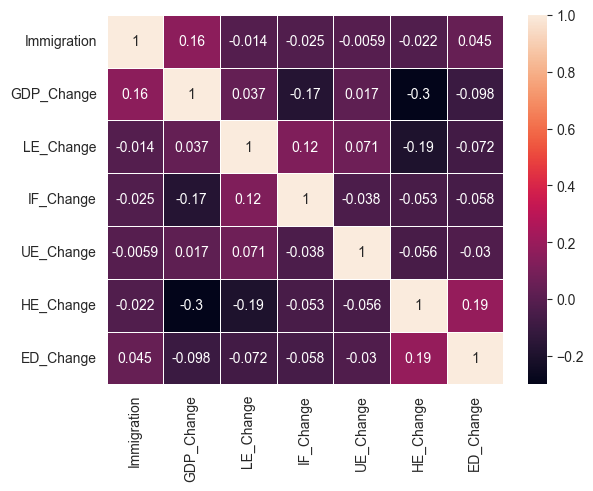

In [17]:
# Generate correlation coefficient heat map.
corr = dataset.corr(numeric_only=True)
sb.heatmap(corr, annot=True, linewidth=0.5)

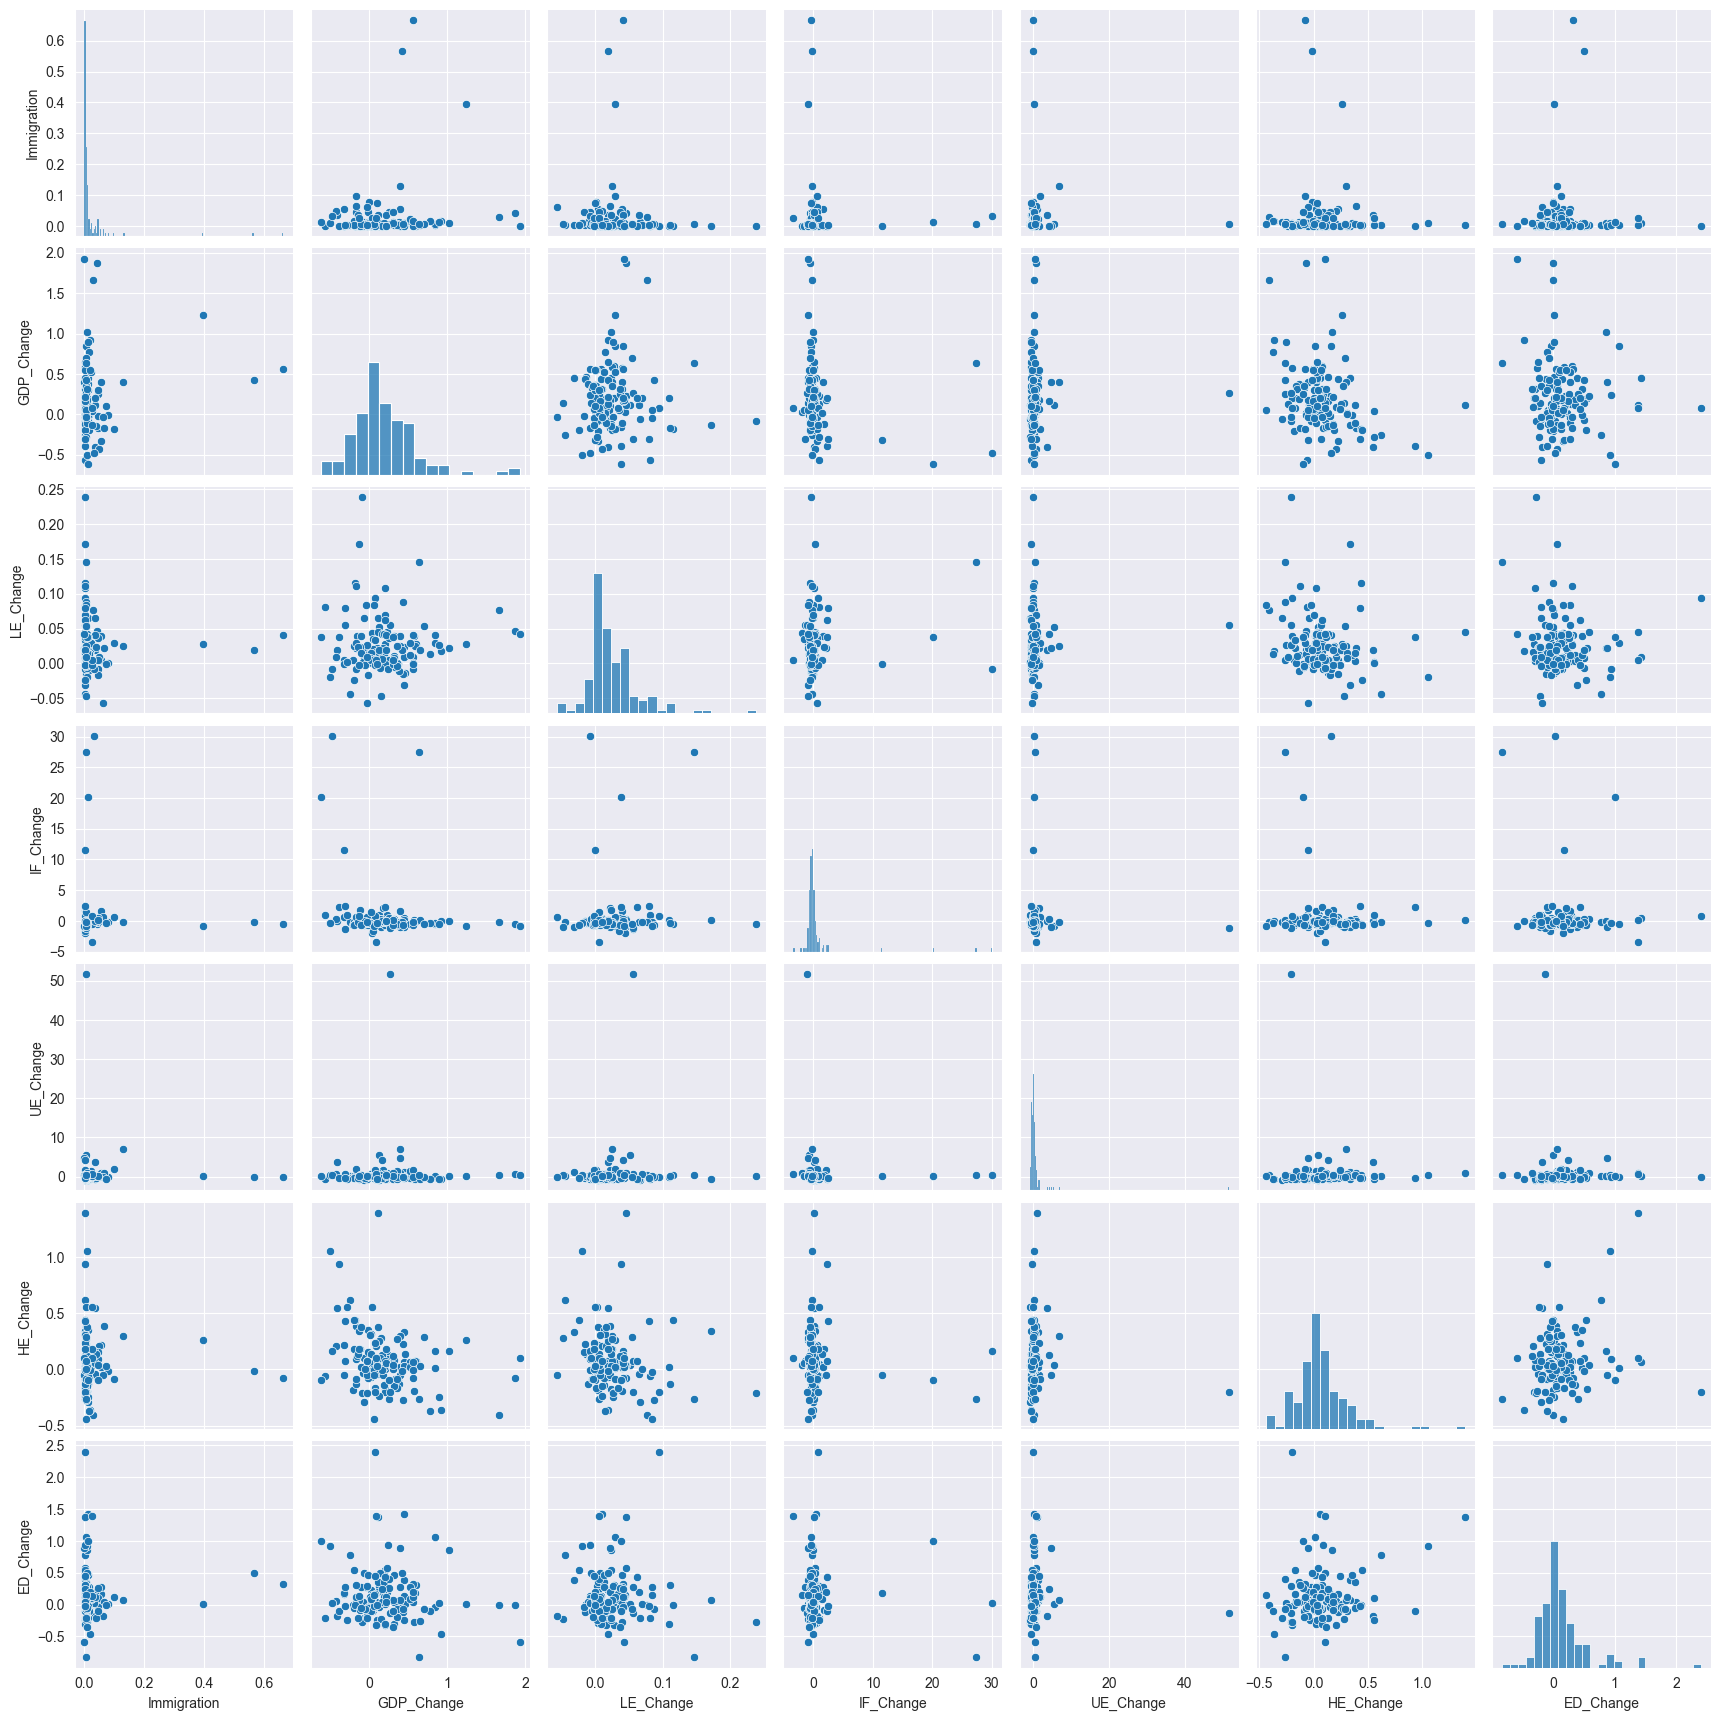

In [18]:
# Generate pairwise graphs based on the dataset.
sb.pairplot(dataset)

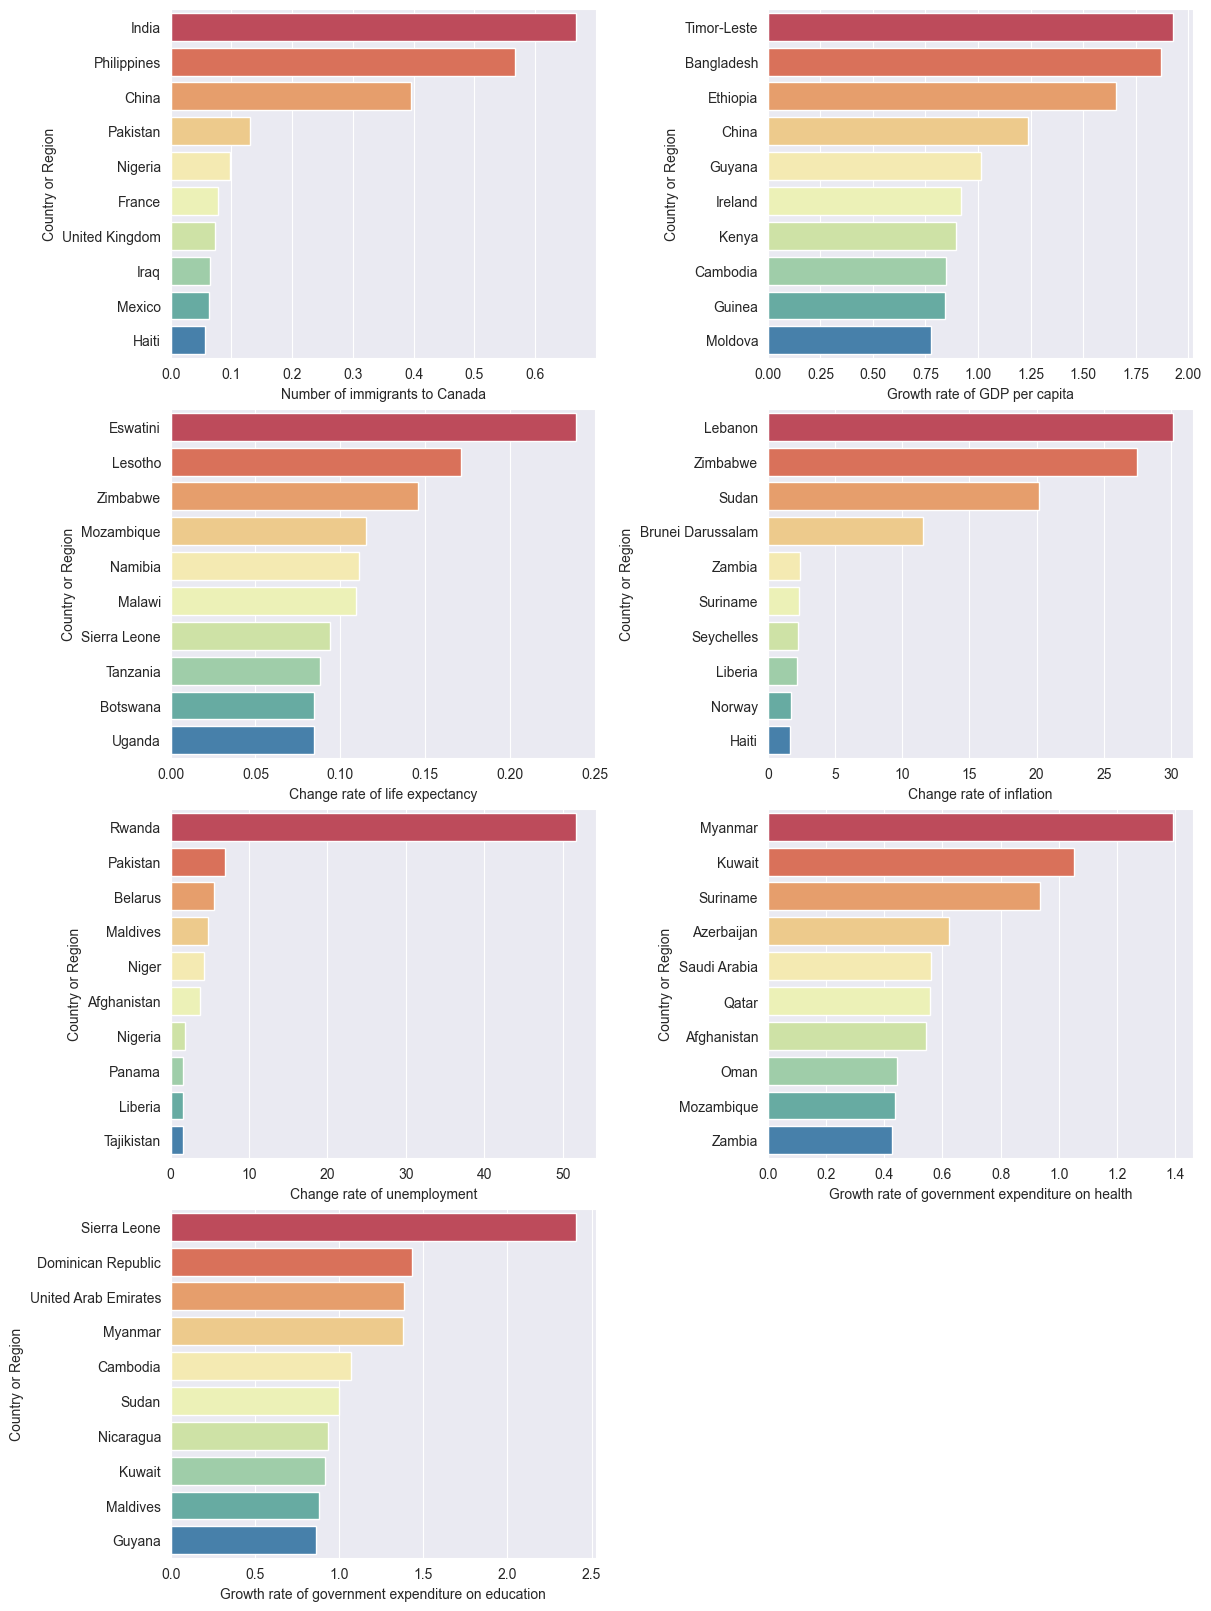

In [19]:
# Display bar graphs for relevant data.
fig, axes = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(12,16))

sb.barplot(x='Immigration', y='Birthplace', data=dataset.nlargest(10, 'Immigration'), ax=axes[0,0], palette="Spectral")\
    .set(xlabel='Number of immigrants to Canada', ylabel='Country or Region')
sb.barplot(x='GDP_Change' ,y='Birthplace', data=dataset.nlargest(10, 'GDP_Change'), ax=axes[0,1], palette="Spectral")\
    .set(xlabel='Growth rate of GDP per capita', ylabel='Country or Region')
sb.barplot(x='LE_Change',y='Birthplace', data=dataset.nlargest(10, 'LE_Change'), ax=axes[1,0], palette="Spectral")\
    .set(xlabel='Change rate of life expectancy', ylabel='Country or Region')
sb.barplot(x='IF_Change' ,y='Birthplace', data=dataset.nlargest(10, 'IF_Change'), ax=axes[1,1], palette="Spectral")\
    .set(xlabel='Change rate of inflation', ylabel='Country or Region')
sb.barplot(x='UE_Change',y='Birthplace', data=dataset.nlargest(10, 'UE_Change'), ax=axes[2,0], palette="Spectral")\
    .set(xlabel='Change rate of unemployment', ylabel='Country or Region')
sb.barplot(x='HE_Change' ,y='Birthplace', data=dataset.nlargest(10, 'HE_Change'), ax=axes[2,1], palette="Spectral")\
    .set(xlabel='Growth rate of government expenditure on health', ylabel='Country or Region')
sb.barplot(x='ED_Change',y='Birthplace', data=dataset.nlargest(10, 'ED_Change'), ax=axes[3,0], palette="Spectral")\
    .set(xlabel='Growth rate of government expenditure on education', ylabel='Country or Region')
fig.delaxes(axes[3,1])

2 clusters, the silhouette score is 0.5559346594893112
3 clusters, the silhouette score is 0.535805232040366
4 clusters, the silhouette score is 0.5111718801416021
5 clusters, the silhouette score is 0.5237143528436443


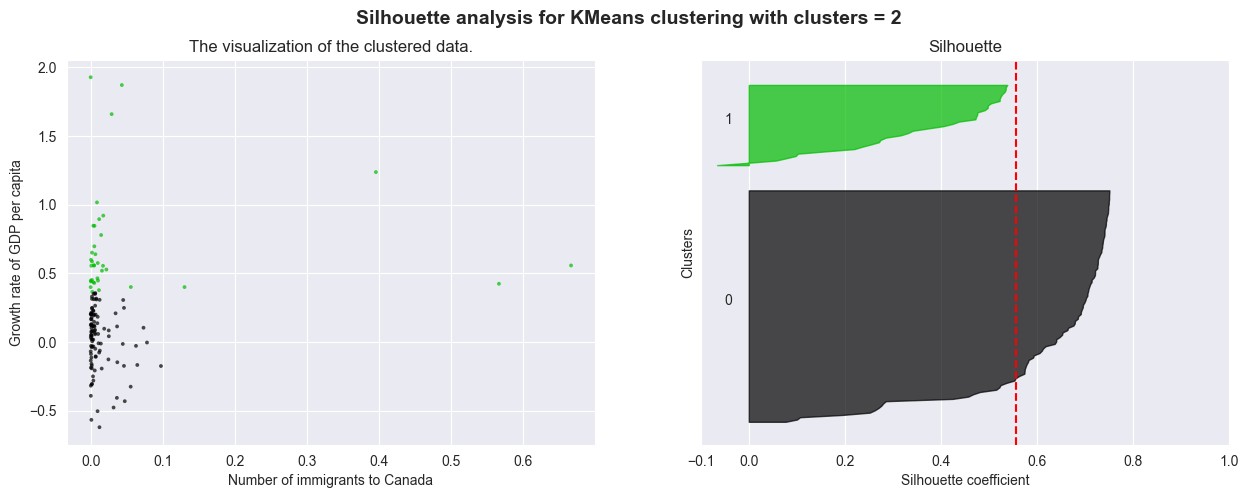

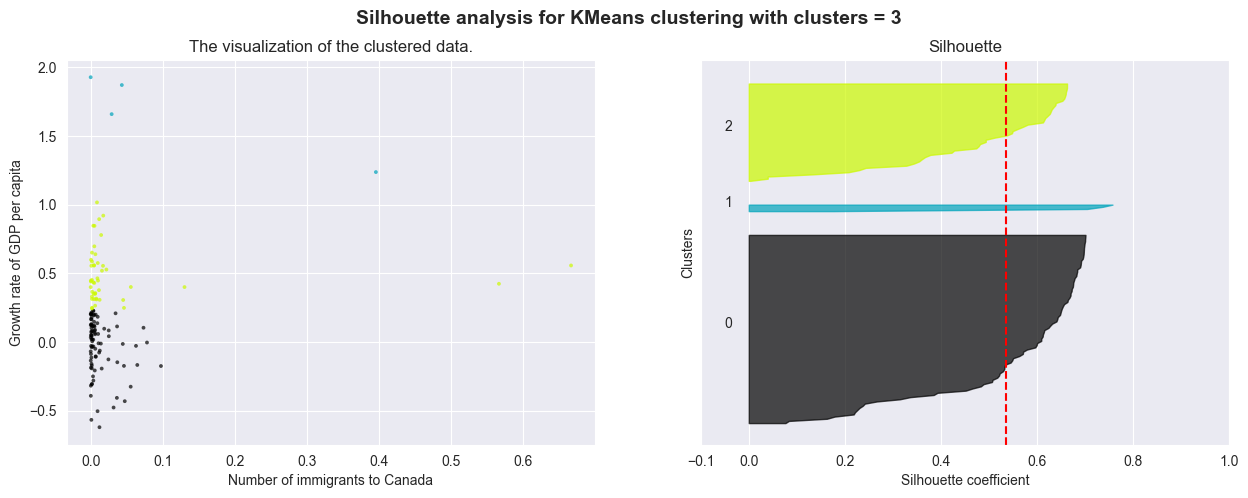

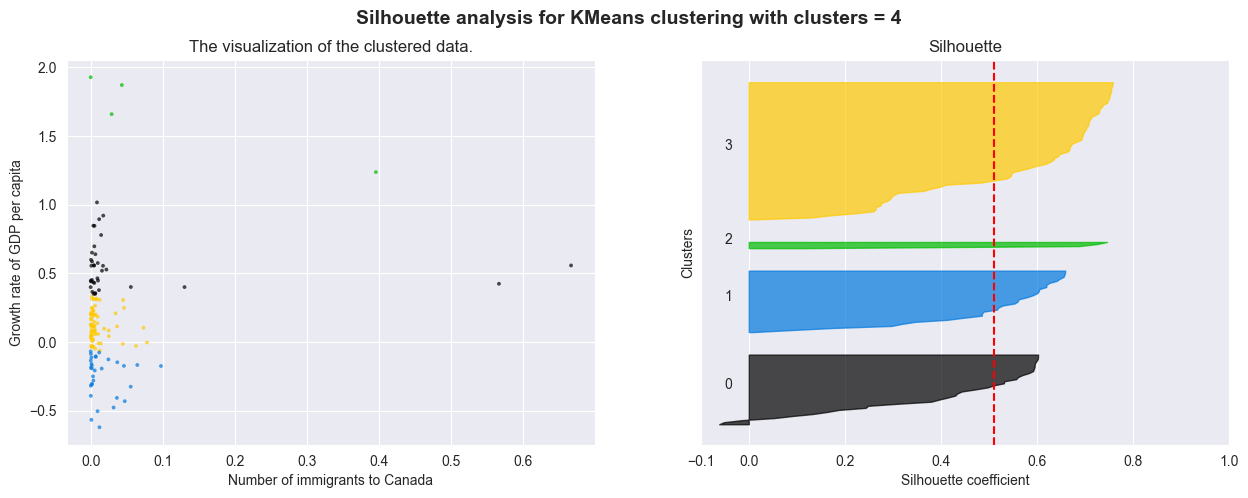

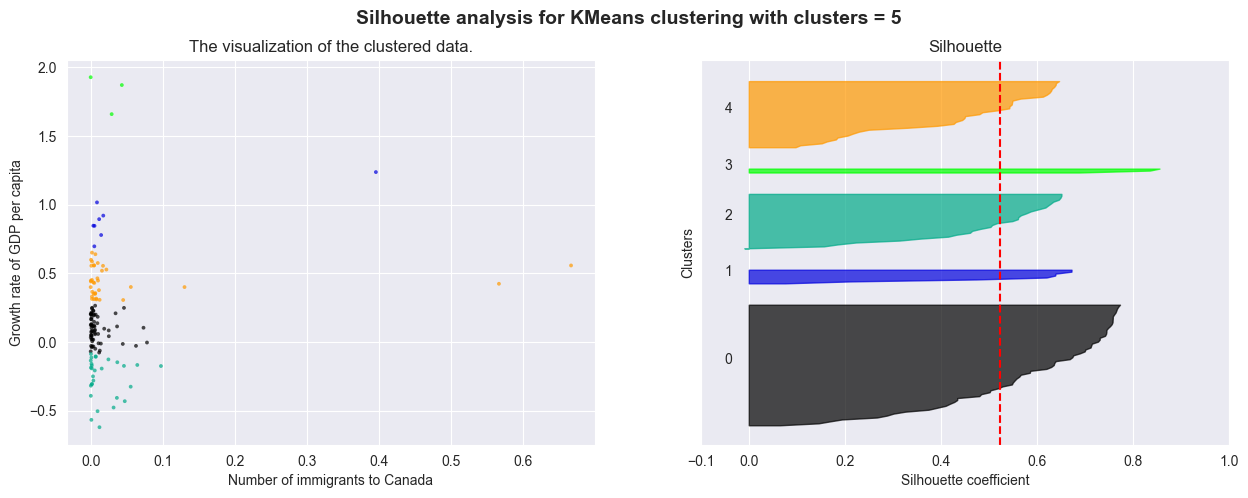

In [21]:
'''
Perform Kmeans clustering on the dataset, calculate the silhouette coefficients, and draw the silhouette plots.
The code used to draw the silhouette plots is from scikit-learn:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

The results and silhouette plots from 2 clusters to 5 clusters are shown separately.
In order to find the most suitable number of clusters for clustering.
'''

for i in range(2, 6):
    X1 = pd.DataFrame({'Immigration':nor[0][:], 'GDP_Change':c}).to_numpy()
    c1 = KMeans(n_clusters=i, random_state=0, n_init=10)
    label1 = c1.fit_predict(X1)
    silhouette = silhouette_score(X1, label1)
    print(i, 'clusters, the silhouette score is', silhouette)

    sample_silhouette = silhouette_samples(X1, label1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(X1) + (i + 1) * 10])
    y_lower = 10

    for n in range(i):
        cluster_silhouette_values = sample_silhouette[label1 == n]
        cluster_silhouette_values.sort()
        cluster_size = cluster_silhouette_values.shape[0]
        y_upper = y_lower + cluster_size
        color = cm.nipy_spectral(n / i)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax2.text(-0.05, y_lower + 0.5 * cluster_size, str(n))
        y_lower = y_upper + 10

    ax2.set_title("Silhouette")
    ax2.set_xlabel("Silhouette coefficient")
    ax2.set_ylabel("Clusters")
    ax2.axvline(x=silhouette, color="red", linestyle="--")
    ax2.set_yticks([])
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(label1.astype(float) / i)
    ax1.scatter(X1[:, 0], X1[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
    ax1.set_title("The visualization of the clustered data.")
    ax1.set_xlabel("Number of immigrants to Canada")
    ax1.set_ylabel("Growth rate of GDP per capita")
    plt.suptitle("Silhouette analysis for KMeans clustering with clusters = %d" % i, fontsize=14, fontweight="bold",)
plt.show()

In [22]:
# By comparing the silhouette coefficients to find the most suitable number of clusters.
def choose_cluster(table):
    score = 0
    n = 0
    for i in range(2, 10):
        c = KMeans(n_clusters=i, random_state=0, n_init=10)
        label = c.fit_predict(table)
        sil = silhouette_score(table, label)
        if sil > score:
            score = sil
            n = i
    print(n, 'clusters, the silhouette score is', score)
    return n

# Perform Kmeans clustering and output the clustering results for each cluster (by country).
def plot_cluster(table, n, x_label):
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    cx = KMeans(n_clusters=n, random_state=0, n_init=10).fit_predict(table)
    plt.figure(figsize=(4,3))

    for j in range(n):
        plt.scatter(table[cx==j, 0], table[cx==j, 1], s=10, c=color[j], label ='Cluster %d'% (j + 1))
        group = []
        for k in range(len(a)):
            if cx[k] == j:
                group.append(a[k])
        print('Cluster %d:'% (j + 1), group)
        group.clear()

    plt.xlabel(x_label)
    plt.ylabel('Number of immigrants to Canada')
    plt.legend()
    plt.show()

2 clusters, the silhouette score is 0.5559346594893112
Cluster 1: ['Afghanistan', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Austria', 'Azerbaijan', 'Bahrain', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Ecuador', 'Eswatini', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Greece', 'Grenada', 'Honduras', 'Hungary', 'Indonesia', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Lebanon', 'Lesotho', 'Liberia', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Mauritius', 'Mexico', 'Mongolia', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Netherlands', 'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia', 'Norway', 'Oman', 'Paraguay', 'Peru', 'Poland', 'Portugal', 'Qatar', 'Russian Federation', 'Rwanda', 'Saudi Arabia', 'Senegal',

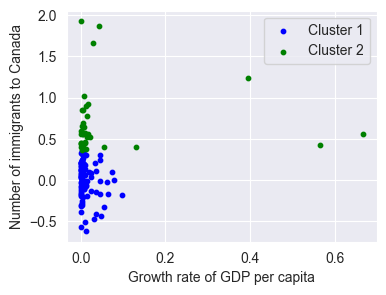

In [23]:
# Clustering using the change in GDP per capita from 2011 to 2021 with the number of immigrants to Canada in this decade.
X1 = pd.DataFrame({'Immigration':nor[0][:], 'GDP_Change':c}).to_numpy()
plot_cluster(X1, choose_cluster(X1), 'Growth rate of GDP per capita')

2 clusters, the silhouette score is 0.9041051456711287
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritan

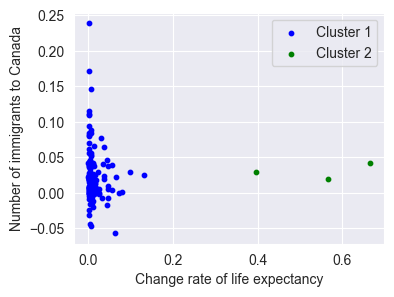

In [24]:
# Clustering using the change in life expectancy from 2011 to 2021 with the number of immigrants to Canada in this decade.
X2 = pd.DataFrame({'Immigration':nor[0][:], 'LE_Change':d}).to_numpy()
plot_cluster(X2, choose_cluster(X2), 'Change rate of life expectancy')

2 clusters, the silhouette score is 0.9805500085303351
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 

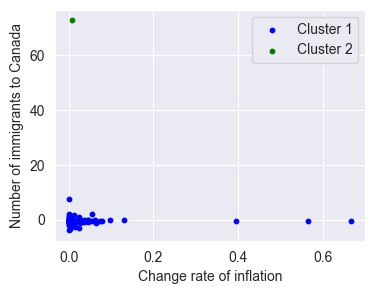

In [16]:
X3 = pd.DataFrame({'Immigration':nor[0][:], 'IF_Change':e}).to_numpy()
plot_cluster(X3, choose_cluster(X3), 'Change rate of inflation')

2 clusters, the silhouette score is 0.9666226850269843
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 

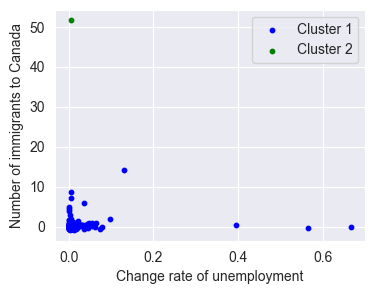

In [17]:
X4 = pd.DataFrame({'Immigration':nor[0][:], 'UE_Change':f}).to_numpy()
plot_cluster(X4, choose_cluster(X4), 'Change rate of unemployment')

2 clusters, the silhouette score is 0.6820200640760807
Cluster 1: ['Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mexico', 'Moldova', 'Mongolia', 

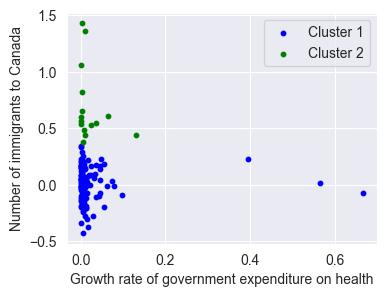

In [18]:
X5 = pd.DataFrame({'Immigration':nor[0][:], 'HE_Change':g}).to_numpy()
plot_cluster(X5, choose_cluster(X5), 'Growth rate of government expenditure on health')

2 clusters, the silhouette score is 0.7180244089964208
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Morocco', 

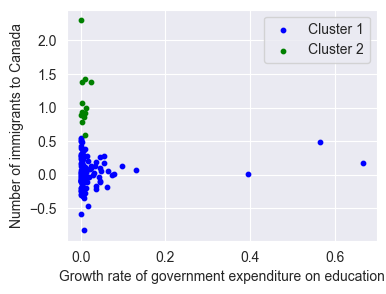

In [19]:
X6 = pd.DataFrame({'Immigration':nor[0][:], 'ED_Change':h}).to_numpy()
plot_cluster(X6, choose_cluster(X6), 'Growth rate of government expenditure on education')

2 clusters, the silhouette score is 0.9549941550573862
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 

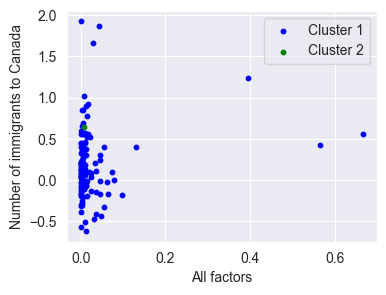

In [20]:
# Clustering with all other indicators using immigrants data.
X7 = dataset.drop(['Birthplace'], axis=1).to_numpy()
plot_cluster(X7, choose_cluster(X7), 'All Factors')

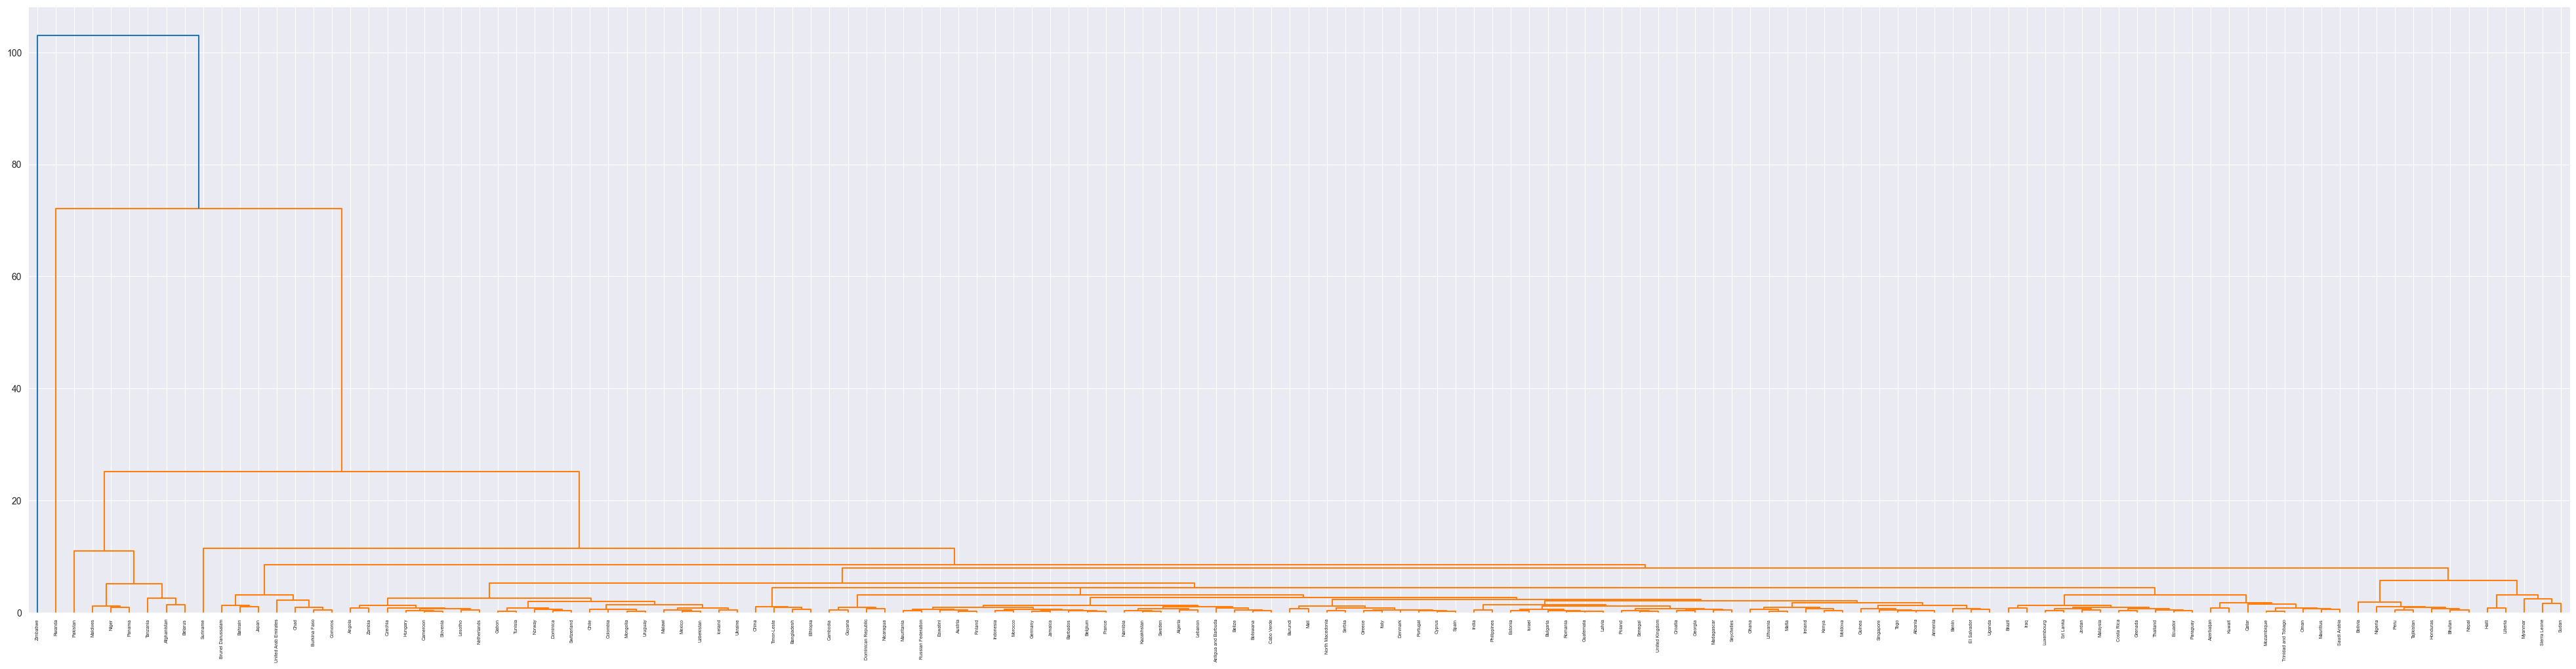

In [21]:
# Hierarchical clustering using the entire dataset.
comb_data = dataset.drop(['Birthplace'], axis=1)
plt.figure(figsize=(50, 12))
dend=sch.dendrogram(sch.linkage(comb_data,method='ward'), labels=a)

# Experiment 2: Study the reasons why Canada attracts immigrants.
### Datasets used: Statistics on net migration to Canada over the years, as and other economic and social indicators of Canada..

In [53]:
cg = pd.read_csv("Datasets/gdp.csv", skiprows=39, nrows=1, usecols=[55, 65]).to_numpy()
cl = pd.read_csv("Datasets/life.csv", skiprows=39, nrows=1, usecols=[55, 64]).to_numpy()
ci = pd.read_csv("Datasets/inflation.csv", skiprows=39, nrows=1, usecols=[55, 65]).to_numpy()
cu = pd.read_csv("Datasets/unemployment.csv", skiprows=39, nrows=1, usecols=[55, 65]).to_numpy()
ch = pd.read_csv("Datasets/health.csv", skiprows=39, nrows=1, usecols=[55, 63]).to_numpy()
ce = pd.read_csv("Datasets/education.csv", skiprows=39, nrows=1, usecols=[55, 64]).to_numpy()
c_rate = [increase_rate(cg[0][0], cg[0][1]), increase_rate(cl[0][0], cl[0][1]), increase_rate(ci[0][0], ci[0][1]), increase_rate(cu[0][0], cu[0][1]), increase_rate(ch[0][0], ch[0][1]), increase_rate(ce[0][0], ce[0][1])]


[-0.0045, 0.0037, 0.1659, -0.0067, 0.0427, -0.0175]